<a href="https://colab.research.google.com/github/teacherSsamko/DL-study/blob/main/w2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [2주차] 기본과제: 주어진 문장에서 나올 다음 단어를 예측하는 모델 구현

# Transformer 실습

이번 실습에서는 감정 분석 task에 RNN 대신 Transformer를 구현하여 적용해 볼 것입니다.
Library import나 dataloader 생성은 RNN 실습 때와 똑같기 때문에 설명은 넘어가도록 하겠습니다.

In [2]:
!pip install datasets sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## [MY CODE] labels를 text의 마지막 두번째 토큰으로 변경

In [3]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    input_ids = tokenizer(row['text'], truncation=True, max_length=max_len).input_ids
    labels.append(input_ids[-2])
    texts.append(
        torch.LongTensor(input_ids[:-2])
    )

  texts = pad_sequence(
      texts,
      batch_first=True,
      padding_value=tokenizer.pad_token_id
  )
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result # 단어 개수 만큼의 크기

In [7]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model) # replace this with MHA
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

In [8]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


In [10]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, -1]
    x = self.classification(x)

    return x


model = TextClassifier(len(tokenizer), 32, 2, 32)

## [MY CODE] CrossEntropyLoss 사용

분류 문제라고 판단되어 CrossEntropyLoss 손실함수로 변경

In [14]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [15]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  model.eval()
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    # preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (preds == labels).sum().item()

  return acc / cnt

In [35]:
n_epochs = 50

for epoch in range(n_epochs):
  total_loss = 0
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').long()

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 1038.411740899086
=========> Train acc: 0.561 | Test acc: 0.562
Epoch   1 | Train Loss: 1025.1521170139313
=========> Train acc: 0.562 | Test acc: 0.563
Epoch   2 | Train Loss: 1012.5476930141449
=========> Train acc: 0.564 | Test acc: 0.566
Epoch   3 | Train Loss: 1001.3719809055328
=========> Train acc: 0.567 | Test acc: 0.567
Epoch   4 | Train Loss: 993.1226650476456
=========> Train acc: 0.566 | Test acc: 0.567
Epoch   5 | Train Loss: 986.2058085203171
=========> Train acc: 0.568 | Test acc: 0.567
Epoch   6 | Train Loss: 974.9525530338287
=========> Train acc: 0.569 | Test acc: 0.569
Epoch   7 | Train Loss: 963.5892022848129
=========> Train acc: 0.570 | Test acc: 0.569
Epoch   8 | Train Loss: 953.3079098463058
=========> Train acc: 0.573 | Test acc: 0.571
Epoch   9 | Train Loss: 942.9845907688141
=========> Train acc: 0.556 | Test acc: 0.550
Epoch  10 | Train Loss: 934.5846314430237
=========> Train acc: 0.575 | Test acc: 0.575
Epoch  11 | Train Loss: 924.3

## [LOG] 학습이 제대로 이루어지지 않음


## [MY CODE] .long() 제거

collate_fn에서 labels를 이미 LongTensor로 만들어주었기 때문에, 여기서는 제거


In [11]:
model = TextClassifier(len(tokenizer), 32, 2, 32)
optimizer = Adam(model.parameters(), lr=lr)
model = model.to('cuda')

In [43]:
n_epochs = 50
train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 1459.9633958339691
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   1 | Train Loss: 1107.548803448677
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   2 | Train Loss: 1057.3668514490128
=========> Train acc: 0.560 | Test acc: 0.562
Epoch   3 | Train Loss: 1034.0473183393478
=========> Train acc: 0.560 | Test acc: 0.562
Epoch   4 | Train Loss: 1027.768927693367
=========> Train acc: 0.560 | Test acc: 0.562
Epoch   5 | Train Loss: 1021.5094847679138
=========> Train acc: 0.560 | Test acc: 0.562
Epoch   6 | Train Loss: 1018.0029919147491
=========> Train acc: 0.561 | Test acc: 0.564
Epoch   7 | Train Loss: 1010.7960010766983
=========> Train acc: 0.564 | Test acc: 0.566
Epoch   8 | Train Loss: 1000.693998336792
=========> Train acc: 0.561 | Test acc: 0.564
Epoch   9 | Train Loss: 992.1834375858307
=========> Train acc: 0.562 | Test acc: 0.566
Epoch  10 | Train Loss: 982.1159181594849
=========> Train acc: 0.565 | Test acc: 0.568
Epoch  11 | Train Loss: 97

In [13]:
def plot_acc(accs1, accs2, label1='', label2='', title=None):
  x = np.arange(len(accs1))

  plt.plot(x, accs1, label=label1)
  plt.plot(x, accs2, label=label2)
  plt.legend()
  if title:
    plt.title(title)
  plt.show()

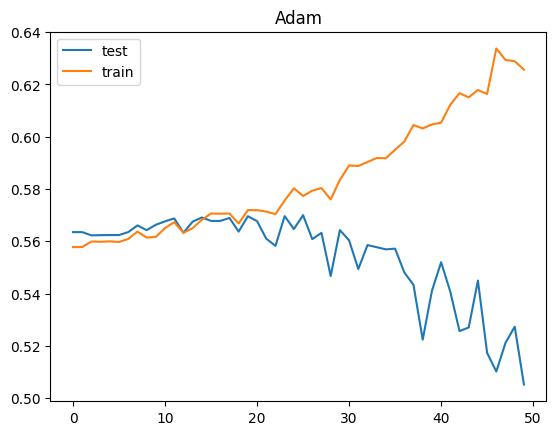

In [45]:
plot_acc(test_acc_list, train_acc_list, 'test', 'train', 'Adam')

## [LOG] 학습도 거의 되지 않고, 과적합 발생

In [46]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

## [LOG] Data 개수 확인

데이터가 적어서 학습이 제대로 이루어지지 않고, 과적합이 발생하는 것으로 보임

## [MY CODE] AdamW & MHA 적용

In [85]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, num_heads, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.num_heads = num_heads
    self.dff = dff

    self.mha = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

    self.layernorm = nn.LayerNorm(d_model, eps=1e-6)
    self.dropout = nn.Dropout(0.1)


  def forward(self, x, mask):
    attn_output, _ = self.mha(x, x, x, key_padding_mask=mask)
    attn_output = self.dropout(attn_output)
    out = self.layernorm(x + attn_output)

    ffn_output = self.ffn(out)
    ffn_output = self.dropout(ffn_output)
    x = self.layernorm(out + ffn_output)

    return x

In [86]:
class MHATextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, num_heads, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, num_heads, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, -1]
    x = self.classification(x)

    return x


model = MHATextClassifier(len(tokenizer), 32, 2, 8, 32)

In [88]:
from torch.optim import AdamW

lr = 0.001

optimizer = AdamW(model.parameters(), lr=lr)
model = model.to('cuda')

In [89]:
n_epochs = 50
train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 1585.1516106128693
=========> Train acc: 0.570 | Test acc: 0.573
Epoch   1 | Train Loss: 1022.5095263719559
=========> Train acc: 0.581 | Test acc: 0.579
Epoch   2 | Train Loss: 960.121618270874
=========> Train acc: 0.590 | Test acc: 0.586
Epoch   3 | Train Loss: 916.8543889522552
=========> Train acc: 0.597 | Test acc: 0.586
Epoch   4 | Train Loss: 877.7410686016083
=========> Train acc: 0.604 | Test acc: 0.586
Epoch   5 | Train Loss: 836.1893665790558
=========> Train acc: 0.615 | Test acc: 0.573
Epoch   6 | Train Loss: 793.1499594449997
=========> Train acc: 0.626 | Test acc: 0.555
Epoch   7 | Train Loss: 747.2033843994141
=========> Train acc: 0.647 | Test acc: 0.573
Epoch   8 | Train Loss: 696.5075252056122
=========> Train acc: 0.671 | Test acc: 0.568
Epoch   9 | Train Loss: 647.0222482681274
=========> Train acc: 0.710 | Test acc: 0.547
Epoch  10 | Train Loss: 600.0516356825829
=========> Train acc: 0.729 | Test acc: 0.539
Epoch  11 | Train Loss: 551.852

KeyboardInterrupt: 

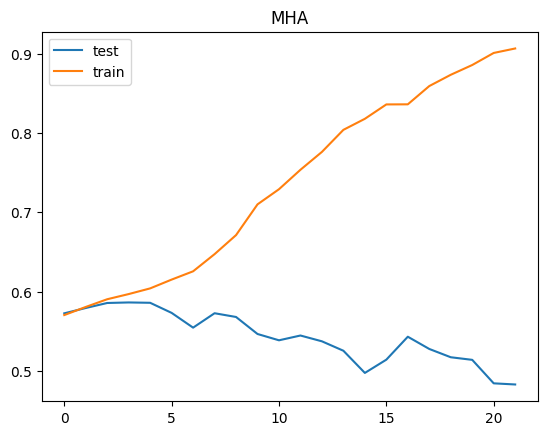

In [90]:
plot_acc(test_acc_list, train_acc_list, 'test', 'train', 'MHA')

## [LOG] MHA로 변경하고 오히려 과적합이 심해짐


## [MY CODE] 데이터 확인

데이터를 왜 마지막이 아닌 -2에서 가져오는지 직접 확인

In [4]:
for i in range(10):
  text = ds['train'][i]['text']
  print(text)

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

## [LOG] Dataset에 \<br/> 태그 확인

## [MY CODE] br 태그 제거

In [5]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    # remove html tag
    clean_text = row['text'].replace('<br />', ' ')
    input_ids = tokenizer(clean_text, truncation=True, max_length=max_len).input_ids
    labels.append(input_ids[-2])
    texts.append(
        torch.LongTensor(input_ids[:-2])
    )

  texts = pad_sequence(
      texts,
      batch_first=True,
      padding_value=tokenizer.pad_token_id
  )
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [16]:
n_epochs = 50
train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 1373.8901323080063
=========> Train acc: 0.584 | Test acc: 0.588
Epoch   1 | Train Loss: 1016.4751360416412
=========> Train acc: 0.584 | Test acc: 0.588
Epoch   2 | Train Loss: 978.7327337265015
=========> Train acc: 0.586 | Test acc: 0.589
Epoch   3 | Train Loss: 961.8870027065277
=========> Train acc: 0.584 | Test acc: 0.586
Epoch   4 | Train Loss: 954.9988210201263
=========> Train acc: 0.587 | Test acc: 0.589
Epoch   5 | Train Loss: 948.6996182203293
=========> Train acc: 0.585 | Test acc: 0.587
Epoch   6 | Train Loss: 943.5479469299316
=========> Train acc: 0.586 | Test acc: 0.588
Epoch   7 | Train Loss: 939.2286055088043
=========> Train acc: 0.588 | Test acc: 0.589
Epoch   8 | Train Loss: 936.6143164634705
=========> Train acc: 0.579 | Test acc: 0.577
Epoch   9 | Train Loss: 930.7699275016785
=========> Train acc: 0.588 | Test acc: 0.589
Epoch  10 | Train Loss: 924.8077528476715
=========> Train acc: 0.589 | Test acc: 0.590
Epoch  11 | Train Loss: 920.26

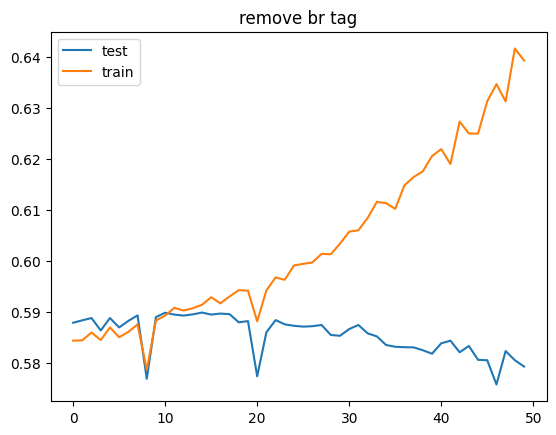

In [17]:
plot_acc(test_acc_list, train_acc_list, 'test', 'train', 'remove br tag')

## [LOG] 여전히 학습이 되지 않고, 과적합만 발생

## [FEEDBACK] 데이터 양의 문제일까요?

BookCorpus나 Wikipedia로 학습을 시키면 나아질 것 같긴한데, 사이즈를 보니까 학습시간이 3~40시간이 걸릴 것 같아서 엄두를 못내겠네요...

접근 방법에서부터 문제가 있는건지
데이터양이 적어서 그런건지 모르겠습니다